In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

### Load and Explore Data

In [3]:
df = pd.read_csv('data/hotel.csv')

In [4]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [5]:
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

### Data Preprocessing

In [6]:
# Split features and target
X = df.copy()
y = X.pop('is_canceled')

# Convert categorical month to numeric
X['arrival_date_month'] = X['arrival_date_month'].map(
    {'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6,
     'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12})

# Define preprocessor with pipelines
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=0)

# Apply transformations to the data
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

### Build the Neural Network Model

In [7]:
# Define the model architecture
model = models.Sequential([
    layers.BatchNormalization(input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

d:\Documents\AI_samsung_2024\py_venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Train the Model with Early Stopping

In [8]:
# Define early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=512, epochs=200, callbacks=[early_stopping])

Epoch 1/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - binary_accuracy: 0.8872 - loss: 0.2318 - val_binary_accuracy: 0.9998 - val_loss: 8.2153e-04
Epoch 2/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.9997 - loss: 0.0012 - val_binary_accuracy: 1.0000 - val_loss: 1.1251e-05
Epoch 3/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.9999 - loss: 3.8308e-04 - val_binary_accuracy: 1.0000 - val_loss: 5.5813e-06
Epoch 4/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.9999 - loss: 2.6121e-04 - val_binary_accuracy: 0.9999 - val_loss: 2.2613e-04
Epoch 5/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 1.0000 - loss: 1.3501e-04 - val_binary_accuracy: 1.0000 - val_loss: 4.5197e-05
Epoch 6/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 1.0000 - loss: 1.4142e-04 - val_binary_accuracy: 0.9998 - val_loss: 4.7283e-04


### Visualize Training History

<Axes: title={'center': 'Binary Accuracy'}>

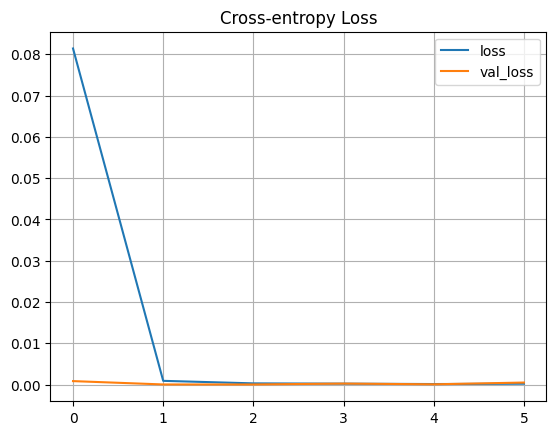

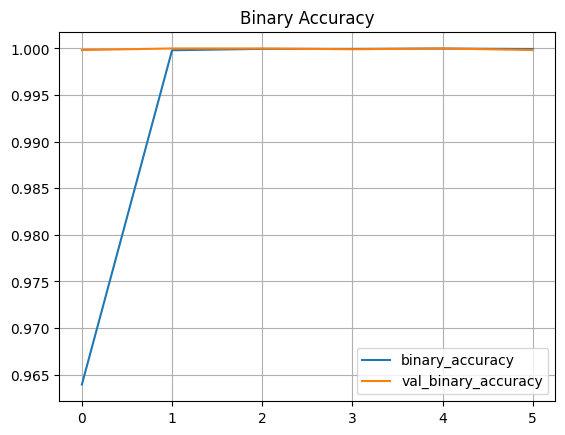

In [9]:
# Convert the history to a DataFrame and plot
history_df = pd.DataFrame(history.history)

# Plot Cross-entropy loss
history_df[['loss', 'val_loss']].plot(title='Cross-entropy Loss', grid=True)

# Plot Binary Accuracy
history_df[['binary_accuracy', 'val_binary_accuracy']].plot(title='Binary Accuracy', grid=True)